In [4]:
import os
from PIL import Image,ImageFont,ImageDraw

import numpy as np
# import scipy as sp
# import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

import os
from PIL import Image,ImageFont,ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import random

## Standard libraries
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt

## Imports for plotting

%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torch import Tensor
from typing import Tuple
import time

def w1_helper(z):
  return torch.sin( 2.0*np.pi/4.0 * z[:,0] )
def w2_helper(z):
  return 3*torch.exp( -0.5*( (z[:,0]-1)/0.6 )**2   )
def sigma_helper(z):
  return 1. / (1. +torch.exp(-z) )
def w3_helper(z):
  return 3*sigma_helper( (z[:,0]-1)/0.3  )

def PotentialU1(z):
  exp1 = torch.exp(  -0.5*((z[:,0]**2-2.0)/0.6)**2 )
  exp2 = torch.exp(  -0.5*((z[:,0]**2+2.0)/0.6)**2 )
  u = 0.5*( ((z[:,0]**2+z[:,1]**2)**0.5-2)/0.4 )**2-safe_log(exp1+exp2) #torch.log(exp1+exp2)
  return u

def PotentialU2(z):
  u = 0.5*( ( z[:,1] - w1_helper(z) )/0.4 )**2
  return u

def PotentialU3(z):
  exp1 = torch.exp( -0.5*( ( z[:,1] - w1_helper(z) )/0.35 )**2 )
  exp2 = torch.exp(  -0.5*( (z[:,1]-w1_helper(z)+w2_helper(z))/0.35   )**2 )
  u = -torch.log(exp1+exp2)
  return u

def PotentialU4(z):
  exp1 = torch.exp( -0.5*( ( z[:,1] - w1_helper(z) )/0.35 )**2 )
  exp2 = torch.exp(  -0.5*( (z[:,1]-w1_helper(z)+w3_helper(z))/0.4   )**2 )
  u = -torch.log(exp1+exp2)
  return u

def safe_log(z):
  return torch.log(z + 1e-7)

# def getEnergyU( theta , z ):
#   return (theta * torch.Tensor([PotentialU1(z),PotentialU2(z),PotentialU3(z),PotentialU4(z)])).sum(-1)

# def getLoss(z , ldj, base_ll, LossFn=PotentialU2):
#   return (base_ll - ldj - safe_log(  torch.exp(-LossFn(z)) ) ).mean()

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [79]:
## Define the problem Here:
dims_theta = 1
dims_input = 2
dims_output = 2
dims_masked = 1

# Define Hyperparamters Here:
max_epochs_for_train = 3000
num_Flows = 6
GatedAffineNet_hidden_layer_size = 32
GatedAffineNet_hidden_layer_num = 2
glb_learming_rate = 1e-3

# Record in a dict
hyperparameter_dict = dict()
hyperparameter_dict["max_epochs_for_train"] = max_epochs_for_train
hyperparameter_dict["num_Flows"] = num_Flows
hyperparameter_dict["GatedAffineNet_hidden_layer_size"] = GatedAffineNet_hidden_layer_size
hyperparameter_dict["GatedAffineNet_hidden_layer_num"] = GatedAffineNet_hidden_layer_num
hyperparameter_dict["glb_learming_rate"] = glb_learming_rate

In [80]:
# Reference: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html
class CostFuncFlow(nn.Module):
    # Forward Direction: from the normal distribution to the target distribution
    def __init__( self, flows ):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0 )
    def forward(self, inp):
        x, ldj, z = self.encode(inp)
        return x
    def encode(self, inp):
        z, ldj, theta = inp[:,:dims_input], torch.zeros(inp.shape[0], device=self.device), inp[:,dims_input:(dims_input+dims_theta)]
        x = z
        for flow in self.flows:
            x, ldj = flow(x, ldj, theta, reverse=False)
        return x, ldj, z
    def sample(self, vec_shape):
        """
        With Gradient! Sample a batch of points from the flow.
        """
        z = self.prior.sample(sample_shape=vec_shape).to(device)
        base_ll = self.prior.log_prob(z).sum(-1)
        ldj = torch.zeros(vec_shape[0], device=device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj, base_ll
    def sampleTrain(self, numToSample):
        """
        With Gradient! Sample a batch of points from the flow.
        """
        z = self.prior.sample(sample_shape=(numToSample,dims_input)).to(device)
        base_ll = self.prior.log_prob(z).sum(-1)
        ldj = torch.zeros(numToSample, device=device)
        theta = torch.from_numpy( np.random.dirichlet(  np.ones(dims_theta) , size=numToSample ) ).type(torch.float).to(device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, theta, reverse=False)
        return z, ldj, base_ll, theta
class CouplingLayer(nn.Module):
    def __init__(self, network, mask, c_in):
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        self.register_buffer('mask', mask)
    def forward(self, z, ldj, theta, reverse=False):
        z_in = z * self.mask
        nn_out = self.network(z_in, theta)
        s, t = nn_out.chunk(2, dim=1)
        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1)
        s = torch.tanh(s / s_fac) * s_fac
        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,])
        return z, ldj
def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32),
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in )
    if invert:
        mask = 1 - mask
    return mask
channel_mask = create_channel_mask(c_in=2).expand(-1,-1)

class ConcatELU(nn.Module):
    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)
      
class GatedAffine(nn.Module):
    def __init__( self, c_in, c_hidden ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(c_in,2*c_in),
        )
    def forward( self, x ):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)

class GatedAffineNet(nn.Module):
    def __init__(self, c_in, c_hidden=4, c_out=-1, num_layers=8):
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        self.c_in = c_in
        self.c_out = c_out
        layers = []
        layers += [nn.Linear(c_in , c_hidden) , nn.ReLU(c_hidden)]
        for layer_index in range(num_layers):
            layers += [GatedAffine(c_in=c_hidden, c_hidden=c_hidden),
                       nn.LayerNorm(c_hidden),
                       nn.ReLU(c_hidden)
                      ]
        layers += [nn.Linear(c_hidden , c_out)]
        self.nn = nn.Sequential(*layers)
        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()
    def forward(self, x, theta):
        # print ( "x ", type(x), " theta ", type(theta))
        # print ( x.shape , theta.shape , self.c_in, self.c_out )
        return self.nn( torch.cat( (x,theta) , dim=1) )
    
def create_simple_flow():
    flow_layers = []
    for i in range( num_Flows ):
        flow_layers += [CouplingLayer(
                network = GatedAffineNet(
                    c_in = dims_input+dims_theta, 
                    c_hidden = GatedAffineNet_hidden_layer_size, 
                    c_out = dims_masked*2, 
                    num_layers = GatedAffineNet_hidden_layer_num
                ),
                mask = create_channel_mask( 2 , invert=(i%2==1) ),
                c_in=dims_input)]
    flow_model = CostFuncFlow(flow_layers).to(device)
    return flow_model


Learning Rate: 0.001
epoch= 0  loss= tensor(-7.4096, device='cuda:0', grad_fn=<MeanBackward0>) time= 0.011590242385864258
epoch= 2000  loss= tensor(-7.8925e+19, device='cuda:0', grad_fn=<MeanBackward0>) time= 17.476255893707275
epoch= 4000  loss= tensor(-5.9659e+20, device='cuda:0', grad_fn=<MeanBackward0>) time= 34.516085147857666
epoch= 6000  loss= tensor(-1.2476e+21, device='cuda:0', grad_fn=<MeanBackward0>) time= 51.7433660030365
epoch= 8000  loss= tensor(-1.8118e+21, device='cuda:0', grad_fn=<MeanBackward0>) time= 68.77648568153381
time for train: 85.93233752250671
epoch= 9999  loss= tensor(-2.4634e+21, device='cuda:0', grad_fn=<MeanBackward0>)


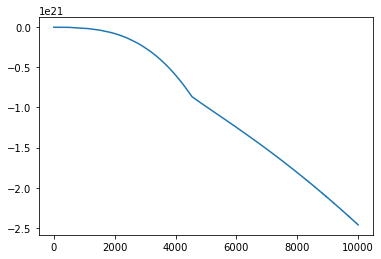

In [87]:
# loss_list_list = []
# for loss_i, loss_fn in enumerate( LossFn_list ):
#     # print ( "Running Loss_fn=",loss_i )
#     assert( loss_fn is not None )

max_epochs_for_train = 10000
net = create_simple_flow()
optimizer = optim.Adam(net.parameters(), lr=glb_learming_rate)
print ( "Learning Rate:", glb_learming_rate)

# optimizer = optim.RMSprop(net.parameters(), lr=5e-5, momentum=0.9)


def getEnergyU( z , theta , energies):
  return theta * energies[0](z)
  # return (theta * torch.Tensor([PotentialU1(z),PotentialU2(z),PotentialU3(z),PotentialU4(z)])).sum(-1)
def getLoss( z , ldj, base_ll, theta, energies=[PotentialU2] ):
  tmp = getEnergyU(z,theta,energies)
  # energy = tmp.where( (tmp<1e6), torch.tensor(1e6).to(device))
  # energy = safe_log( torch.exp(-tmp) )
  energy = -tmp
  return (base_ll - ldj + energy ).mean()
  # return (- base_ll - ldj + energy ).mean()
  return ( energy ).mean()

loss_list = []
seconds_st = time.time()
for epoch in range(max_epochs_for_train):
    optimizer.zero_grad()
    
    d_out, d_ldj_out, base_ll, d_theta = net.sampleTrain(400)
    # print ( "Sampled: ", d_out.shape, d_ldj_out.shape, base_ll.shape, d_theta.shape )
    loss = getLoss( d_out, d_ldj_out, base_ll, d_theta, energies=[PotentialU2])
    # print ( "epoch" , epoch ,d_out, d_ldj_out, loss )
    loss_list.append(loss.cpu().detach().numpy())

    loss.backward()
    optimizer.step()

    if ( epoch % 2000 == 0 ):
        print ( "epoch=",epoch , " loss=",loss, "time=", time.time()-seconds_st )
    if ( epoch % 10000 == 0 ):
        torch.save(net.state_dict(), "./model_u2_k8_"+str(epoch)+"auto_save"+str( (int)(time.time())%1000 ) )

print ( "time for train:", time.time()-seconds_st )
print ( "epoch=", epoch, " loss=",loss )  # print ( d_out[:,0] )
# fig1 = plt.figure(loss_i*3+1)
plt.plot(range(len(loss_list)) , loss_list)
# showResult(net , loss_i*3+2 )
# plot_density2d(model=net, id=loss_i*3+3, limit=4.0, step=0.01)
torch.save(net.state_dict(), "./model_test_vc_"+str(max_epochs_for_train)+"_dimsTheta"+str(dims_theta)) #+"_time_"+str( (int)(time.time())%10000 ))


CostFuncFlow(
  (flows): ModuleList(
    (0): CouplingLayer(
      (network): GatedAffineNet(
        (nn): Sequential(
          (0): Linear(in_features=3, out_features=32, bias=True)
          (1): ReLU(inplace=True)
          (2): GatedAffine(
            (net): Sequential(
              (0): Linear(in_features=32, out_features=64, bias=True)
            )
          )
          (3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (4): ReLU(inplace=True)
          (5): GatedAffine(
            (net): Sequential(
              (0): Linear(in_features=32, out_features=64, bias=True)
            )
          )
          (6): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (7): ReLU(inplace=True)
          (8): Linear(in_features=32, out_features=2, bias=True)
        )
      )
    )
    (1): CouplingLayer(
      (network): GatedAffineNet(
        (nn): Sequential(
          (0): Linear(in_features=3, out_features=32, bias=True)
          (1): ReLU(inplace=Tr

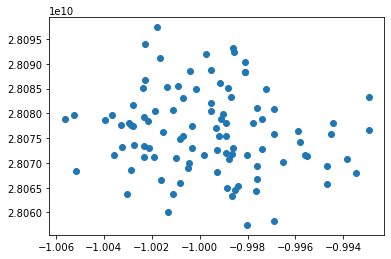

In [88]:
print ( net )
with torch.no_grad():
    d_out, d_ldj_out, base_ll, d_theta = net.sampleTrain(100)
    loss = getLoss( d_out, d_ldj_out, base_ll, d_theta, energies=[PotentialU1])
    print ( np.min(d_theta.cpu().numpy()) )
    print ( "Loss=", loss )
    print ( "U=", PotentialU1(d_out).mean() )
    points = d_out.cpu().numpy()
    print ( points.shape )
    plt.scatter( points[:,0] , points[:,1] )

In [27]:
import numpy as np
np.random.dirichlet(np.ones(2),size=2)
# type(np.ones(1))

array([[0.40127119, 0.59872881],
       [0.9263444 , 0.0736556 ]])